Reading config file: /opt/anaconda3/envs/deepforest/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


/opt/anaconda3/envs/deepforest/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/deepforest/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NEON.pt: 129MB [00:23, 5.49MB/s]                                                                                                       
/opt/anaconda3/envs/deepforest/lib/python3.12/site-packages/deepforest/main.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded 

Model was downloaded and saved to /opt/anaconda3/envs/deepforest/lib/python3.12/site-packages/deepforest/data/NEON.pt
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


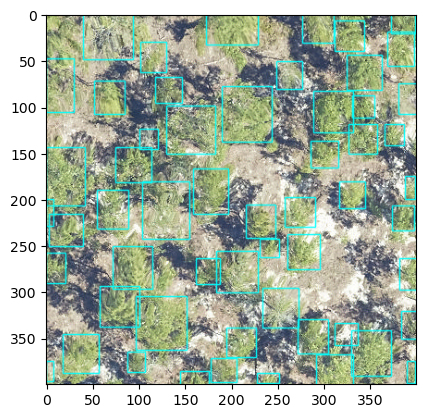

In [ ]:
from deepforest import main
from deepforest import get_data
import matplotlib.pyplot as plt

model = main.deepforest()
model.use_release()

sample_image_path = get_data("OSBS_029.png")
img = model.predict_image(path=sample_image_path, return_plot=True)

#predict_image returns plot in BlueGreenRed (opencv style), but matplotlib likes RedGreenBlue, switch the channel order. Many functions in deepforest will automatically perform this flip for you and give a warning.
plt.imshow(img[:,:,::-1])


In [ ]:
!pip install git+https://github.com/opengeos/samgeo.git

  Cloning https://github.com/opengeos/samgeo.git to /private/var/folders/1t/dkxc365s3kx04cd1hhnbhmh00000gn/T/pip-req-build-nu79xxw3
  Running command git clone --filter=blob:none --quiet https://github.com/opengeos/samgeo.git /private/var/folders/1t/dkxc365s3kx04cd1hhnbhmh00000gn/T/pip-req-build-nu79xxw3
Username for 'https://github.com': 

In [ ]:
from deepforest import main
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from samgeo.text_sam import LangSAM
from shapely.geometry import box

# Load DeepForest model
model = main.deepforest()
model.use_release()  # Use pre-trained model

# Load SAMGeo for automatic object detection
sam = LangSAM()

# Define input TIFF file
tif_path = "3318DC_16_2016_1143_RGB_RECT.tif"

# Read the TIFF image
with rasterio.open(tif_path) as src:
    image = src.read([1, 2, 3]).transpose(1, 2, 0)  # Read RGB bands
    transform = src.transform  # Spatial transformation
    crs = src.crs  # Coordinate Reference System

# Normalize image for better visualization
image = (image - np.min(image)) / (np.max(image) - np.min(image))

# Use SAMGeo to detect objects (trees & buildings)
sam_boxes = sam.generate_boxes(tif_path, text_prompt="trees and buildings")

# Convert detected bounding boxes to DeepForest format
df_boxes = []
for box_coords in sam_boxes:
    x_min, y_min, x_max, y_max = box_coords
    df_boxes.append({"xmin": x_min, "ymin": y_min, "xmax": x_max, "ymax": y_max})

# Convert pixel-based bounding boxes to geospatial coordinates
geometries = []
for box in df_boxes:
    x_min, y_min, x_max, y_max = box["xmin"], box["ymin"], box["xmax"], box["ymax"]

    # Convert pixel coordinates to real-world coordinates
    x_min_geo, y_min_geo = rasterio.transform.xy(transform, y_min, x_min)
    x_max_geo, y_max_geo = rasterio.transform.xy(transform, y_max, x_max)

    # Create a bounding box polygon
    bbox = box(x_min_geo, y_min_geo, x_max_geo, y_max_geo)
    geometries.append(bbox)

# ✅ Create a GeoDataFrame with the detected bounding boxes
gdf = gpd.GeoDataFrame(geometry=geometries, crs=crs)

# ✅ Save to a Shapefile or GeoJSON (optional)
gdf.to_file("detected_objects.shp")  # Save as a shapefile
gdf.to_file("detected_objects.geojson", driver="GeoJSON")  # Save as a GeoJSON

# ✅ Run DeepForest on detected bounding boxes
tree_boxes = model.predict_image(path=tif_path, return_plot=False)

# ✅ Convert DeepForest tree detections to geospatial coordinates
tree_geometries = []
for _, row in tree_boxes.iterrows():
    x_min, y_min, x_max, y_max = row["xmin"], row["ymin"], row["xmax"], row["ymax"]

    x_min_geo, y_min_geo = rasterio.transform.xy(transform, y_min, x_min)
    x_max_geo, y_max_geo = rasterio.transform.xy(transform, y_max, x_max)

    bbox = box(x_min_geo, y_min_geo, x_max_geo, y_max_geo)
    tree_geometries.append(bbox)

# ✅ Create a GeoDataFrame with the detected trees
tree_gdf = gpd.GeoDataFrame(geometry=tree_geometries, crs=crs)

# ✅ Save detected trees
tree_gdf.to_file("detected_trees.shp")  # Save as a shapefile
tree_gdf.to_file("detected_trees.geojson", driver="GeoJSON")  # Save as a GeoJSON

# ✅ Plot results: Image + Bounding Boxes
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)  # Plot the TIFF image
gdf.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=2, label="SAM-Detected Objects")  # Plot SAM bounding boxes
tree_gdf.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2, label="DeepForest Trees")  # Plot DeepForest trees

plt.legend()
plt.title("Object Detection (SAM) + Tree Detection (DeepForest)")
plt.show()


ModuleNotFoundError: No module named 'samgeo'